In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
import copy
from pprint import pprint

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

import gensim
from gensim.models import *
from gensim.models.fasttext import FastText
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.metrics import *
from sklearn.svm import *

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_with_sentiment_v2.csv')
tweets_neg_df = tweets_df[tweets_df['sentiment_flair']==-1]
tweets_neg_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk,sentiment_flair_glove_embed_kmeans,sentiment_fast_text_embed_kmeans,sentiment_fast_text_embed_nmf_kmeans
0,0,very bad thing say that government did not med...,Mumbai,2022,"['very', 'bad', 'thing', 'say', 'that', 'gover...",-1,-1,-1,-1,1
1,1,all netas and their family should admitted onl...,Mumbai,2022,"['all', 'netas', 'and', 'their', 'family', 'sh...",-1,-1,-1,-1,1
5,5,very hygiene government veterinary hospital as...,Mumbai,2022,"['very', 'hygiene', 'government', 'veterinary'...",-1,1,-1,-1,-1
7,7,shall throw out india let take care our health...,Mumbai,2022,"['shall', 'throw', 'out', 'india', 'let', 'tak...",-1,1,-1,-1,1
9,9,not online school wild guess going south mumba...,Mumbai,2022,"['not', 'online', 'school', 'wild', 'guess', '...",-1,-1,-1,1,-1


In [3]:
tfidf = TfidfVectorizer(lowercase=False)
x_tfidf = tfidf.fit_transform(tweets_neg_df['tweet'])
x_tfidf_numpy = x_tfidf.toarray()

In [4]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = tweets_neg_df['tweet'].values.tolist()
data_words = list(sent_to_words(data))
len(data_words)

9897

In [5]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(bigram_mod, trigram_mod)

FrozenPhrases<239 phrases, min_count=5, threshold=100> FrozenPhrases<272 phrases, min_count=5, threshold=100>


In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
import spacy
spacy.load('en_core_web_sm')

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
len(data_lemmatized)

9897

In [8]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
print(type(id2word), type(texts), type(corpus))
print(corpus)

<class 'gensim.corpora.dictionary.Dictionary'> <class 'list'> <class 'list'>
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 2), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1)], [(4, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(1, 1), (4, 1), (20, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(1, 1), (4, 1), (20, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1)], [(4, 1), (7, 2), (11, 1), (20, 1), (49, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1)], [(0, 1), (1, 1), (3, 1), (4, 2), (10, 1), (20, 2), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)], [(4, 1), (16, 1), (20, 1), (33, 1), (55, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80,

In [10]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
print(doc_lda)

[(0,
  '0.084*"understand" + 0.070*"mean" + 0.059*"hospital" + 0.040*"doctor" + '
  '0.012*"government" + 0.010*"patient" + 0.007*"get" + 0.007*"poor" + '
  '0.007*"significant" + 0.006*"terminal"'),
 (1,
  '0.068*"hospital" + 0.029*"poor" + 0.026*"doctor" + 0.021*"people" + '
  '0.019*"get" + 0.014*"treatment" + 0.013*"patient" + 0.013*"pay" + '
  '0.013*"money" + 0.011*"government"'),
 (2,
  '0.070*"hospital" + 0.021*"terminal" + 0.018*"doctor" + 0.016*"patient" + '
  '0.012*"take" + 0.012*"dead" + 0.009*"report" + 0.008*"death" + '
  '0.007*"injure" + 0.007*"bad"'),
 (3,
  '0.048*"take" + 0.047*"road" + 0.043*"action" + 0.032*"hospital" + '
  '0.016*"ambulance" + 0.013*"traffic" + 0.013*"police" + 0.012*"parking" + '
  '0.011*"vehicle" + 0.010*"park"'),
 (4,
  '0.041*"doctor" + 0.034*"hospital" + 0.014*"service" + 0.011*"bad" + '
  '0.008*"call" + 0.007*"terminal" + 0.007*"come" + 0.007*"staff" + '
  '0.006*"today" + 0.006*"even"'),
 (5,
  '0.087*"guess" + 0.067*"wild" + 0.047*"hosp

In [15]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38910974088975714


In [11]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_npmi')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# # Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
            
            pbar.update(1)
    pd.DataFrame(model_results).to_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/lda_tuning_results.csv', index=False)
    pbar.close()

496it [3:46:25, 27.39s/it]                           


<Axes: xlabel='Topics', ylabel='Coherence'>

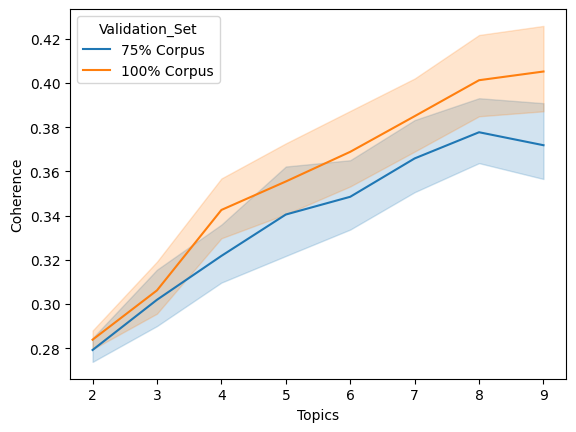

In [12]:
lda_results = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/lda_tuning_results.csv')
sns.lineplot(x='Topics', y='Coherence', hue='Validation_Set', data=lda_results)

In [13]:
lda_results[lda_results['Coherence']==max(lda_results['Coherence'])]

,Validation_Set,Topics,Alpha,Beta,Coherence
477,100% Corpus,9,asymmetric,0.61,0.540384


In [14]:
num_topics = 9

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.61)

In [15]:
import pyLDAvis.gensim_models as gensimvis
import os
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.296298  0.064725       1        1  74.755649
1      0.145603 -0.106123       2        1  15.938929
2     -0.033882 -0.025826       3        1   3.839610
3     -0.070907  0.014429       4        1   1.233225
4     -0.071055  0.013619       5        1   1.197653
5     -0.068186  0.011430       6        1   0.915001
7     -0.067734  0.009549       7        1   0.881357
6     -0.065930  0.009224       8        1   0.710699
8     -0.064205  0.008972       9        1   0.527876, topic_info=                Term         Freq        Total Category  logprob  loglift
58             guess  1381.000000  1381.000000  Default  30.0000  30.0000
65              wild  1054.000000  1054.000000  Default  29.0000  29.0000
20          hospital  7939.000000  7939.000000  Default  28.0000  28.0000
81            oxygen   696.000000   696.000000  Default  27.0000  27.0000
93         condition  1004.000000  1004.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
3912          mainly     0.288326     7.083287   Topic9  -7.9982   2.0427
3769           saheb     0.280792     9.564208   Topic9  -8.0247   1.7159
5862             jet     0.254976     7.373157   Topic9  -8.1212   1.8796
2651      conspiracy     0.243618     5.051729   Topic9  -8.1667   2.2122
3883  pharma_company     0.238727     8.258102   Topic9  -8.1870   1.7004

[443 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
7355       1  0.527822  academic
7355       7  0.263911  academic
2763       1  0.027653    accuse
2763       2  0.940190    accuse
268        1  0.732023    action
...      ...       ...       ...
11893      2  0.334379       woo
11893      8  0.334379       woo
7182       1  0.169904      yard
7182       2  0.169904      yard
7182       3  0.679616      yard

[957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 8, 7, 9])

In [21]:
lda_model.print_topics(5, num_words=10)[:]

[(8,
  '0.001*"buy" + 0.001*"meal" + 0.001*"clock" + 0.001*"defame" + 0.001*"impression" + 0.001*"appetite" + 0.001*"hathway" + 0.001*"pilot" + 0.000*"villager" + 0.000*"premiere"'),
 (7,
  '0.001*"lodge" + 0.001*"weight" + 0.001*"app" + 0.001*"fit" + 0.001*"rumour" + 0.001*"percent" + 0.001*"diet" + 0.001*"hang" + 0.001*"rajya" + 0.001*"cbi"'),
 (2,
  '0.009*"condition" + 0.009*"unhygienic" + 0.008*"dead" + 0.007*"injure" + 0.006*"fire" + 0.005*"action" + 0.005*"garbage" + 0.004*"road" + 0.004*"hospital" + 0.003*"take"'),
 (1,
  '0.031*"hospital" + 0.028*"guess" + 0.022*"wild" + 0.018*"oxygen" + 0.015*"lack" + 0.014*"road" + 0.013*"due" + 0.013*"die" + 0.011*"terminal" + 0.009*"condition"'),
 (0,
  '0.058*"hospital" + 0.028*"doctor" + 0.019*"understand" + 0.015*"mean" + 0.012*"patient" + 0.010*"government" + 0.009*"get" + 0.009*"poor" + 0.009*"people" + 0.008*"terminal"')]

In [27]:
train_vecs = []
for i in range(len(tweets_df)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(5)]
    # topic_vec.extend([tweets_neg_df.iloc[i].tweet])
    topic_vec.extend([len(tweets_df.iloc[i].tweet)])
    train_vecs.append(topic_vec)

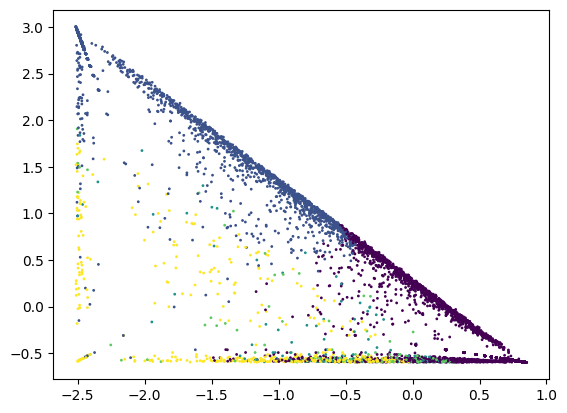

In [36]:
x = np.array(train_vecs)

scaler = StandardScaler()
x_scale = scaler.fit_transform(x)

model_kmeans = KMeans(n_clusters=5, max_iter=2000, random_state=42).fit(X=x_scale)
cluster_center_document_0 = model_kmeans.cluster_centers_[0]
cluster_center_document_1 = model_kmeans.cluster_centers_[1]
cluster_center_document_2 = model_kmeans.cluster_centers_[2]
cluster_center_document_3 = model_kmeans.cluster_centers_[3]
cluster_center_document_4 = model_kmeans.cluster_centers_[4]


plt.scatter(x_scale[:,0], x_scale[:,1], c=model_kmeans.labels_, cmap='viridis', s=1)

In [ ]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=The%20above%20LDA%20model%20is,certain%20weightage%20to%20the%20topic.